In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import sklearn

from first_nn_test_helpers import *
random_seed_number = 123

In [3]:
n_spectra_each_box = 10000
gps_list = [i for i in range(50)]
base_path = "/vera/u/jerbo/my_ptmp/L25n256_suite"
gp_paths = [base_path+f"/gridpoint{i}/" for i in gps_list]
df = load_dataset(gp_paths, load_n_spect_per_file=1000, total_spectra_per_file=n_spectra_each_box)
df.head()

,lambda 0,lambda 1,lambda 2,lambda 3,lambda 4,lambda 5,lambda 6,lambda 7,lambda 8,lambda 9,...,lambda 4672,lambda 4673,lambda 4674,lambda 4675,lambda 4676,lambda 4677,Omega m,Omega b,Omega Lambda,h
0,3543.0,3543.8159,3544.631988,3545.448263,3546.264727,3547.081378,3547.898218,3548.715246,3549.532462,3550.349866,...,10388.937949,10391.330366,10393.723334,10396.116853,10398.510923,10400.905544,NaN,NaN,NaN,NaN
1,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.4798,0.0953,0.5202,0.5689
2,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.4798,0.0953,0.5202,0.5689
3,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.4798,0.0953,0.5202,0.5689
4,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.4798,0.0953,0.5202,0.5689


### Split into x data frame and y data frame

In [4]:
params = ["Omega m", "Omega b", "Omega Lambda", "h"]
y_data_frame = df[params]
y_data_frame = y_data_frame.drop(index=0).reset_index(drop=True)  # drop first row, as it holds no information

x_data_frame = df[df.columns[df.columns.str.startswith("lambda")]]

In [5]:
x_data_frame.head()

,lambda 0,lambda 1,lambda 2,lambda 3,lambda 4,lambda 5,lambda 6,lambda 7,lambda 8,lambda 9,...,lambda 4668,lambda 4669,lambda 4670,lambda 4671,lambda 4672,lambda 4673,lambda 4674,lambda 4675,lambda 4676,lambda 4677
0,3543.0,3543.8159,3544.631988,3545.448263,3546.264727,3547.081378,3547.898218,3548.715246,3549.532462,3550.349866,...,10379.373789,10381.764003,10384.154768,10386.546083,10388.937949,10391.330366,10393.723334,10396.116853,10398.510923,10400.905544
1,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
y_data_frame.head()

,Omega m,Omega b,Omega Lambda,h
0,0.4798,0.0953,0.5202,0.5689
1,0.4798,0.0953,0.5202,0.5689
2,0.4798,0.0953,0.5202,0.5689
3,0.4798,0.0953,0.5202,0.5689
4,0.4798,0.0953,0.5202,0.5689


### Cut away unused wavelengths

In [7]:
lower_cutoff = 3640
upper_cutoff = 3700

wavelengths = x_data_frame.loc[0]
mask = (wavelengths >= lower_cutoff) & (wavelengths <= upper_cutoff)
cols_to_keep = wavelengths[mask].index

x_data_frame_filtered = x_data_frame[cols_to_keep]
n_input_neurons = len(cols_to_keep)

# throw away wavelength information as it is no longer needed 
x_data_frame_filtered = x_data_frame_filtered.drop(index=0).reset_index(drop=True)

x_data_frame_filtered.head()

,lambda 118,lambda 119,lambda 120,lambda 121,lambda 122,lambda 123,lambda 124,lambda 125,lambda 126,lambda 127,...,lambda 179,lambda 180,lambda 181,lambda 182,lambda 183,lambda 184,lambda 185,lambda 186,lambda 187,lambda 188
0,1.0,0.999998,0.999994,0.999986,0.999975,0.999886,0.998585,0.987073,0.929892,0.776620,...,0.999568,0.999635,0.999688,0.99973,0.999764,0.999792,0.999815,0.999834,0.999851,0.999865
1,1.0,1.000000,1.000000,1.000000,0.999985,0.999694,0.996676,0.980515,0.934164,0.856091,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.0,1.000000,0.999999,0.999977,0.999634,0.995995,0.971937,0.876325,0.657319,0.384639,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.0,1.000000,1.000000,1.000000,0.999996,0.999926,0.999126,0.993102,0.962147,0.856149,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.0,1.000000,1.000000,1.000000,1.000000,0.999995,0.999925,0.999350,0.996662,0.989750,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
x_data = torch.tensor(x_data_frame_filtered.values, dtype=torch.float)
y_data = torch.tensor(y_data_frame.values, dtype=torch.float)

In [9]:
n_test = 5000

# select training data
y_train = y_data[:-n_test]
x_train = x_data[:-n_test]

# select test data
y_test = y_data[-1*n_test:]
x_test = x_data[-1*n_test:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# create a loader object to handle data from here on
xy_train = torch.utils.data.TensorDataset(x_train,y_train)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(y_train)/2), shuffle=True)

torch.Size([45000, 71])
torch.Size([45000, 4])
torch.Size([5000, 71])
torch.Size([5000, 4])


In [16]:
round(n_input_neurons)

71

In [20]:
torch.manual_seed(random_seed_number)
# create the neural network
net = torch.nn.Sequential(
    torch.nn.Linear(n_input_neurons, round(n_input_neurons)),
    torch.nn.ReLU(),
    torch.nn.Linear(round(n_input_neurons), round(n_input_neurons/2)),
    torch.nn.ReLU(),
    torch.nn.Linear(round(n_input_neurons/2), 4))
# set lossfunction
loss_fn = torch.nn.MSELoss()
# set optimizer and learningrate
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

print("Number of network parameters:", np.sum([np.prod(theta.shape) for theta in net.parameters()]))

Number of network parameters: 7852


Completed epoch  0 in  1.0s, Train loss=6.5e-01, Test loss=3.4e-02
Completed epoch 50 in 37.5s, Train loss=5.0e-03, Test loss=6.3e-03
Completed epoch 100 in 32.7s, Train loss=6.0e-03, Test loss=7.5e-03
Completed epoch 150 in 35.2s, Train loss=3.8e-03, Test loss=4.8e-03


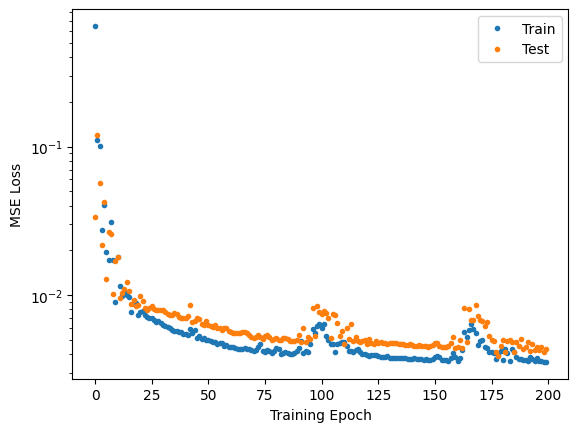

In [21]:
losses = []
losses_test = []
eta = 200
start_time = time.time()
for epoch in range(eta):
    net.train()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() 
    y_pred = net(x_test)
    test_loss = loss_fn(y_pred, y_test)
    losses_test.append(test_loss.data)
    if epoch % (eta/4) == 0:
        end_time=time.time()
        elapsed_time = end_time - start_time
        print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))
        start_time = time.time()
        
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.savefig("plots/lossfct_net_guess_par.pdf", format="pdf")

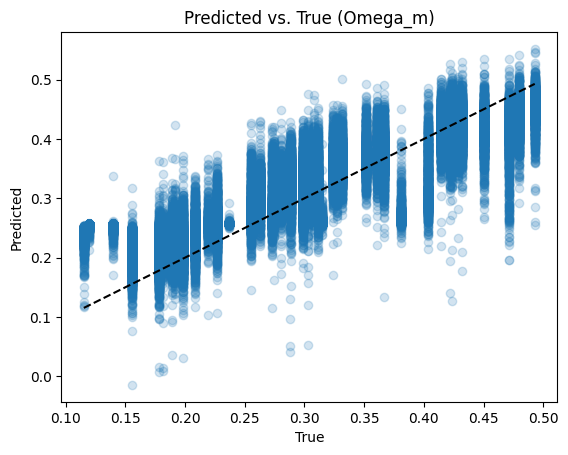

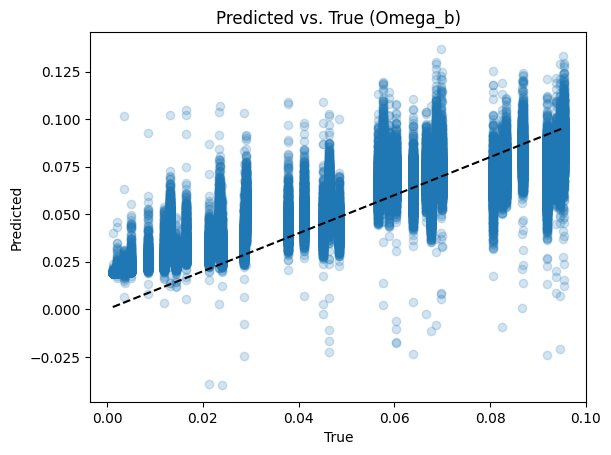

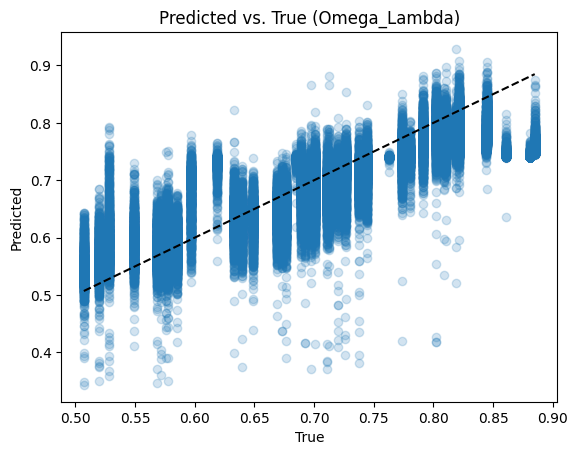

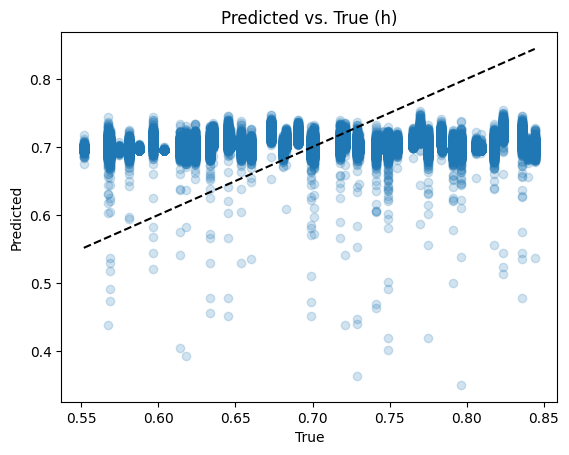

In [22]:
# get the prediction of the network for the test dataset
# net.load_state_dict(torch.load('net.pth')) # comment this line in if you want to use a saved network state instead of the current one
y_pred = net(x_train)

label = ["Omega_m", "Omega_b", "Omega_Lambda", "h"]

for j in range(4):
    predicted = []
    true = []
    # loop through predictions to get the labels
    for i in range(len(y_pred)):
        # get the predicted label as the index of the max value as described above (see one hot encoding)
        predicted.append(y_pred[i][j].detach().numpy())
        true.append(y_train[i][j])

    

    plt.scatter(true, predicted, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], c="black", linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs. True ({label[j]})")
    plt.show()